In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Getting DataSets

In [ ]:
train_data_dir='./DataSets/Training'
validation_data_dir='./DataSets/Validating'

In [ ]:
for expression in os.listdir(train_data_dir+"/"):
    print(str(len(os.listdir(train_data_dir+"/" + expression))) + " " + expression + " images")

560 Angry images
680 Happy images
616 Neutral images
704 Sad images


In [ ]:
for expression in os.listdir(validation_data_dir+"/"):
    print(str(len(os.listdir(validation_data_dir+"/" + expression))) + " " + expression + " images")

248 Angry images
296 Happy images
264 Neutral images
288 Sad images


# Samples of DataSet

In [ ]:
from IPython.display import Image, display
os.chdir("./DataSets/Sample")
img=[]
for file in os.listdir("./DataSets/Sample"):
    img.append(file)
for i in img:
    display(Image(filename=i))

# Image Augmentation

In [ ]:
num_classes=4
img_rows,img_cols=100,100
batch_size=16

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_data_dir,
 color_mode='grayscale',
 target_size=(img_rows,img_cols),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 validation_data_dir,
 color_mode='grayscale',
 target_size=(img_rows,img_cols),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 2560 images belonging to 4 classes.
Found 1096 images belonging to 4 classes.


In [ ]:
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.6.0 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
assert torch.__version__.startswith("1.6")
!pip install detectron2==0.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


# Buliding Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
checkpoint = ModelCheckpoint('DogEmotionDetectionModel.h5',
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.2, 
                              patience = 3, 
                              verbose = 1, 
                              min_delta = 0.0001)
callbacks = [checkpoint]

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer = Adam(lr=0.001),
 metrics=['accuracy'])

nb_train_samples = 2560
nb_validation_samples = 1096
epochs=100


In [ ]:
history=model.fit(
 train_generator,
 steps_per_epoch=nb_train_samples//batch_size,
 epochs=epochs,
 callbacks=callbacks,
 validation_data=validation_generator,
 validation_steps=nb_validation_samples//batch_size)

Epoch 1/100
160/160 [==============================] - 148s 921ms/step - loss: 2.0335 - accuracy: 0.2803 - val_loss: 2.1970 - val_accuracy: 0.1719

Epoch 00001: val_loss improved from inf to 2.19700, saving model to DogEmotionDetectionModel_9.h5
Epoch 2/100
160/160 [==============================] - 151s 944ms/step - loss: 1.8042 - accuracy: 0.2512 - val_loss: 1.3041 - val_accuracy: 0.4182

Epoch 00002: val_loss improved from 2.19700 to 1.30414, saving model to DogEmotionDetectionModel_9.h5
Epoch 3/100
160/160 [==============================] - 152s 947ms/step - loss: 1.5781 - accuracy: 0.2885 - val_loss: 1.3135 - val_accuracy: 0.3888

Epoch 00003: val_loss did not improve from 1.30414
Epoch 4/100
160/160 [==============================] - 152s 951ms/step - loss: 1.4999 - accuracy: 0.3127 - val_loss: 1.2979 - val_accuracy: 0.4108

Epoch 00004: val_loss improved from 1.30414 to 1.29789, saving model to DogEmotionDetectionModel_9.h5
Epoch 5/100
160/160 [==============================] - 


Epoch 00077: val_loss did not improve from 0.47954
Epoch 78/100
160/160 [==============================] - 92s 572ms/step - loss: 0.6712 - accuracy: 0.7498 - val_loss: 0.7618 - val_accuracy: 0.7050

Epoch 00078: val_loss did not improve from 0.47954
Epoch 79/100
160/160 [==============================] - 91s 570ms/step - loss: 0.6872 - accuracy: 0.7470 - val_loss: 0.6830 - val_accuracy: 0.7574

Epoch 00079: val_loss did not improve from 0.47954
Epoch 80/100
160/160 [==============================] - 91s 569ms/step - loss: 0.7100 - accuracy: 0.7284 - val_loss: 0.6266 - val_accuracy: 0.7619

Epoch 00080: val_loss did not improve from 0.47954
Epoch 81/100
160/160 [==============================] - 92s 573ms/step - loss: 0.6860 - accuracy: 0.7405 - val_loss: 0.5692 - val_accuracy: 0.7803

Epoch 00081: val_loss did not improve from 0.47954
Epoch 82/100
160/160 [==============================] - 90s 562ms/step - loss: 0.6377 - accuracy: 0.7562 - val_loss: 0.6445 - val_accuracy: 0.7537

Epoc

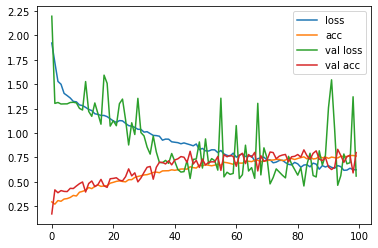

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


In [ ]:
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Confusion Matrix
[[225  19   1   3]
 [ 24 222  39  11]
 [ 34  83  70  77]
 [  8  16  21 243]]


In [ ]:
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       Angry       0.77      0.91      0.83       248
       Happy       0.65      0.75      0.70       296
     Neutral       0.53      0.27      0.35       264
         Sad       0.73      0.84      0.78       288

    accuracy                           0.69      1096
   macro avg       0.67      0.69      0.67      1096
weighted avg       0.67      0.69      0.67      1096



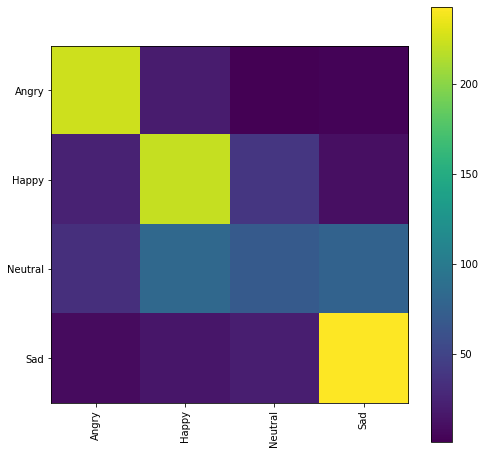

In [ ]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

# Loading Model and test it on Sample Datasets

In [ ]:
from keras.models import load_model

classifier = load_model('./DogEmotionDetectionModel_5.h5')

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 1096 images belonging to 4 classes.
{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad'}


In [ ]:
from keras.models import load_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 100, 100

# We use a very small learning rate 
classifier.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 20):
    path = 'C:/Users/rajla/OneDrive/Desktop/SEM 6/DE/DataSets/Testing/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 16)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=1, fy=1, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

def draw_test(name, pred, im):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)


img = cv2.imread("./test.jfif")

gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
gray=cv2.resize(gray,(100,100), interpolation = cv2.INTER_AREA)
im=gray.astype("float")/255.0
im=img_to_array(im)
im=np.expand_dims(im,axis=0)
preds=classifier.predict(im)[0]
label=class_labels[preds.argmax()]
draw_test("Prediction", label, img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import os

os.chdir("./DataSets/Sample")
for file in os.listdir("./DataSets/Sample"):
    img = cv2.imread(file)
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    gray=cv2.resize(gray,(100,100), interpolation = cv2.INTER_AREA)
    im=gray.astype("float")/255.0
    im=image.img_to_array(im)
    im=np.expand_dims(im,axis=0)
    preds=classifier.predict(im)[0]
    label=class_labels[preds.argmax()]
    draw_test("Prediction",label, img)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
pip install face-recognition==1.3.0

     |████████████████████████████████| 100.1 MB 32 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=aad6a967eda9c400a0092e39af398b41ec38eb202aaee67c4def26b9ce0ab640
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [ ]:

import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.framework import ops
tf.compat.v1.disable_eager_execution()

In [ ]:

def build_model():
 
    return VGG16(include_top=True, weights='imagenet')

H, W = 224, 224

In [ ]:
from PIL import Image

img = Image.open('/content/Untitled Folder/aggressive-rottweiler-barking-mad-260nw-598929575.jpg')
imgGray = img.convert('L')
imgGray.save('/content/Untitled Folder/test_gray.jpg')

In [ ]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [ ]:

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (W, H), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [ ]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [ ]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    for c, p in zip(classes, top):
        print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    if cls == -1:
        cls = np.argmax(predictions)
    class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [ ]:
model = build_model()
guided_model = build_guided_model()

553476096/553467096 [==============================] - 5s 0us/step


Result folder has been emptied.
---------------------------------------------------


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


/content/Untitled Folder/aggressive-rottweiler-barking-mad-260nw-598929575.jpg --> /content/sample_data/001Angry.jpg
Model prediction:
	Rottweiler     	(234)	with probability 0.693
	Doberman       	(236)	with probability 0.186
	black-and-tan_coonhound	(165)	with probability 0.036
	miniature_pinscher	(237)	with probability 0.019
	Brabancon_griffon	(262)	with probability 0.019
Explanation for 'Rottweiler'


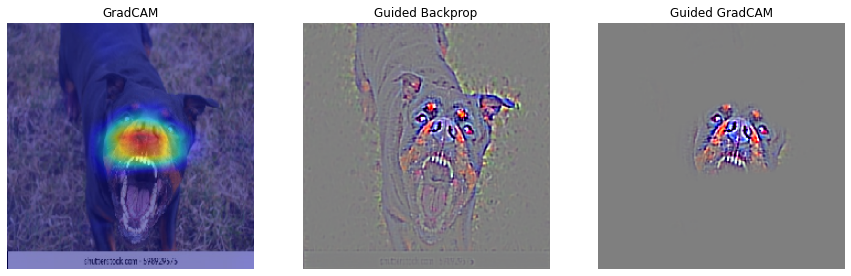

  emotion      prob
0   Angry  0.998547
1  Scared  0.001035
2   Happy  0.000328
3     Sad  0.000091
---------------------------------------------------
/content/Untitled Folder/test_gray.jpg --> /content/sample_data/002Angry.jpg
Model prediction:
	Rottweiler     	(234)	with probability 0.693
	Doberman       	(236)	with probability 0.186
	black-and-tan_coonhound	(165)	with probability 0.036
	miniature_pinscher	(237)	with probability 0.019
	Brabancon_griffon	(262)	with probability 0.019
Explanation for 'Rottweiler'


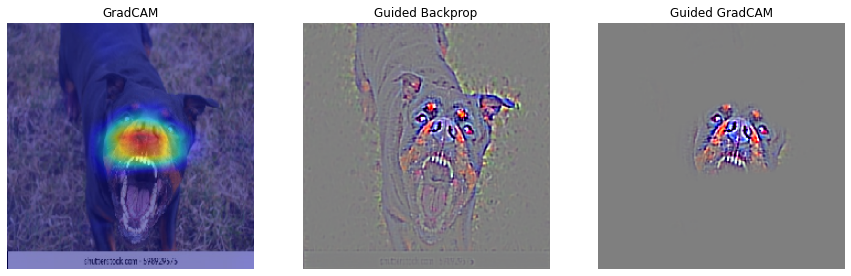

  emotion      prob
0   Angry  0.998832
1  Scared  0.000856
2   Happy  0.000245
3     Sad  0.000067


In [ ]:
from keras.models import load_model
from helper import No_Preprocessing
import dlib
import cv2
from imutils import face_utils
import imutils
import numpy as np
import math
import os
import shutil



img_width = 64
img_height = 64

picSize = 200
rotation = True

path = '/content/Untitled Folder'
pathResult = '/content/sample_data'


pathDet = '/content/dogHeadDetector.dat'
detector = dlib.cnn_face_detection_model_v1(pathDet)


pathPred = '/content/landmarkDetector.dat'
predictor = dlib.shape_predictor(pathPred)


helper = No_Preprocessing(img_width, img_height)

model1 = load_model('/content/DogEmotionDetectionModel_5.h5')


def preprocess(path):

  orig = cv2.imread(path)

  if orig.any() == True:
  
    height, width, channels = orig.shape  
    ratio = picSize / height
    image = cv2.resize(orig, None, fx=ratio, fy=ratio)

    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    dets = detector(gray, upsample_num_times=1)

    imageList = []  # for return
    for i, d in enumerate(dets):
      # save coordinates
      x1 = max(int(d.rect.left() / ratio), 1)
      y1 = max(int(d.rect.top() / ratio), 1)
      x2 = min(int(d.rect.right() / ratio), width - 1)
      y2 = min(int(d.rect.bottom() / ratio), height - 1)

      # detect landmarks
      shape = face_utils.shape_to_np(predictor(gray, d.rect))
      points = []
      index = 0
      for (x, y) in shape:
        x = int(round(x / ratio))
        y = int(round(y / ratio))
        index = index + 1
        if index == 3 or index == 4 or index == 6:
          points.append([x, y])
      points = np.array(points) # right eye, nose, left eye

      # rotate
      if rotation == True:
        xLine = points[0][0] - points[2][0]
        if points[2][1] < points[0][1]:
          yLine = points[0][1] - points[2][1]
          angle = math.degrees(math.atan(yLine / xLine))
        else:
          yLine = points[2][1] - points[0][1]
          angle = 360 - math.degrees(math.atan(yLine / xLine))
        rotated = imutils.rotate(orig, angle)
       
      cv2.polylines(orig, [points], True, (0, 255, 0), 1)
      cv2.rectangle(orig, (x1, y1), (x2, y2), (255, 0, 0), 1)
      imageList.append(orig)

      
      little = cv2.resize((rotated[y1:y2, x1:x2]), (img_width, img_height)) 
      pixel = cv2.cvtColor(little, cv2.COLOR_BGR2GRAY)
      x = np.expand_dims(pixel, axis=0)
      x = x.reshape((-1, 64, 64, 1))
      imageList.append(x)
      return imageList 
  return None



#delete old results
if os.path.isdir(pathResult) == True:
    shutil.rmtree(pathResult)
    print('Result folder has been emptied.')
os.mkdir(pathResult)


counter = 0

#loop over all images
for filename in sorted(os.listdir(path)):
  if filename != ".DS_Store":
    print('---------------------------------------------------')
    counter = counter + 1
    pathImage = path + "/" + filename
    fileType = (filename.split('.'))[-1]

    # read and preprocess image
    images = preprocess(pathImage)
    if images != None: #found face on image
      x = images[1]
      marked = images[0]

      df = helper.predict_emotion(model1, x)

      # sort and extract most probable emotion
      df = df.sort_values(by='prob', ascending=False)
      emotion = df['emotion'].values[0]
      prob = str(round((df['prob'].values[0])*100, 2))

      newPath = pathResult + '/' + str("{:03d}".format(counter)) + emotion + '.' + fileType

      height, width, channels = marked.shape  # read size
      overlay = marked.copy() # save orig
      # draw semi-transparent layer
      cv2.rectangle(marked, (0, 0), (width, 45), (0, 0, 0), -1)
      marked = cv2.addWeighted(marked, 0.5, overlay, 0.5, 0)

     
      text = emotion + ': ' + prob + '%'

     
      cv2.putText(marked, # image
                  text,
                  (10, 30),  # text position
                  cv2.FONT_HERSHEY_SIMPLEX, # font
                  0.6, # fontScale
                  (255, 255, 255),  # font color
                  1,  
                  cv2.LINE_AA)

      cv2.imwrite(newPath, marked)  
      print(pathImage + " --> " + newPath)
      gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, '/content/Untitled Folder/aggressive-rottweiler-barking-mad-260nw-598929575.jpg', layer_name='block5_conv3', 
                                               cls=-1, visualize=True, save=False)
    
      print(df)

